# Deep Learning with PyTorch : Build a Generative Adversarial Network

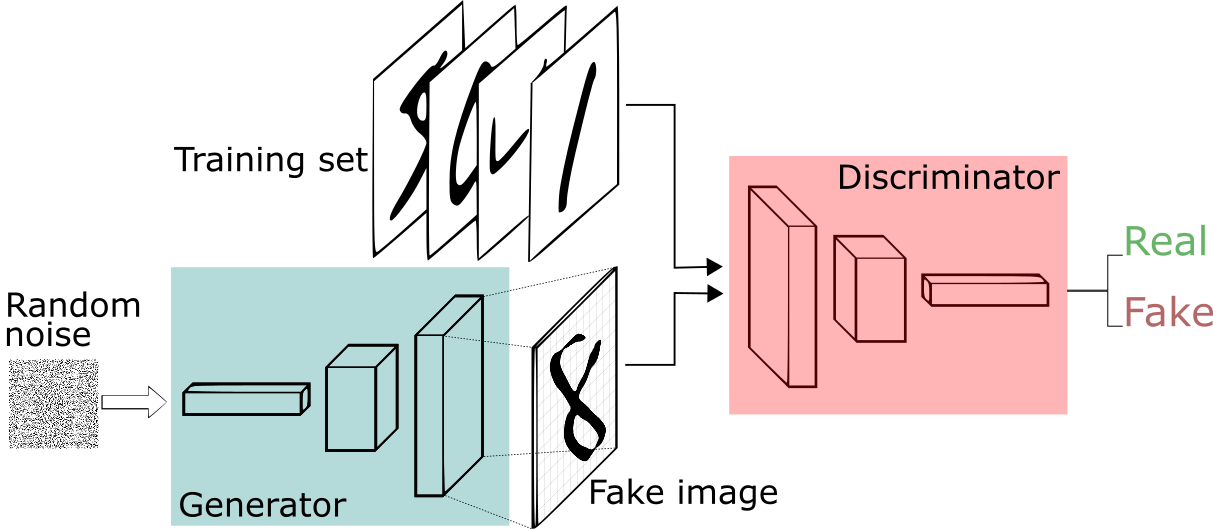

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
# Since we are using GPU we need to specify device ...it is used to transfer tensor or images to GPU
device = 'cuda' # image = image.to(device)
batch_size = 128 # trainloader, training loop
noise_dim = 64

# Optimizer parameters
# Adam optimizer
lr = 0.002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20,+20)), # rotates a degree chosen randomly between -20 and 20
    T.ToTensor() #(h, w, c) -> (c, h, w)
])

In [ ]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17435760.85it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 474487.44it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4343078.03it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4061946.43it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



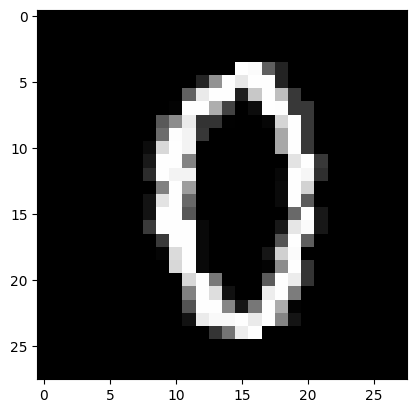

In [ ]:
image, label = trainset[1000]
# squeeze removes single dimentional entrie -> (1,h,w) == (h,w) it accepts only two dimentional entries
plt.imshow(image.squeeze(), cmap = 'gray')

In [ ]:
print(len(trainset)) # Total no of images in trainset

60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True) # shuffle shuffles dataset at each epoch

In [ ]:
print("Total number of batches in train loader: ",len(trainloader))

Total number of batches in train loader:  469


In [ ]:
dataiter = iter(trainloader) # get an iterator to iterate over batches of dataloader
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu() # dont track gradients for visualizaion and move to cpu from gpu as matplotlib works on cpu only
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze()) # permute (c,h,w)->(h,w,c) as plt expects last dim to be color channels
    plt.show()

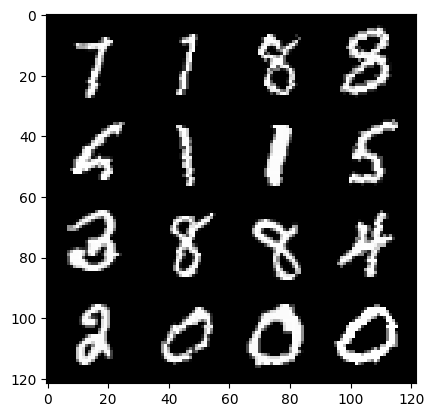

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

Generator creates image from noise and discriminator tells us what is real or fake image probability .Look at the shapes of each layer of the model accordingly


In [ ]:
from torch import nn
from torchsummary import summary # providing summary of model

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)

  )

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13) # ((n+2p-m)/s)+1 floor division
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64) #(bs,c,h,w) ->(bs,features)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

Purpose of Batch Normalization

Stabilizes Training:
Normalizes the input to each layer so that they have a mean of zero and a standard deviation of one. This helps in reducing internal covariate shift, which is the change in the distribution of network activations due to the change in network parameters during training.

Speeds Up Training:
Allows for higher learning rates because the network is more stable and less likely to diverge. This often results in faster convergence.

Regularizes the Model:
Adds a bit of noise to the activations in each mini-batch due to the normalization process, which can have a regularization effect and reduce the need for other forms of regularization like Dropout.


In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block1 = get_disc_block(1, 16, (3,3), 2)
    self.block2 = get_disc_block(16, 32, (5,5), 2)
    self.block3 = get_disc_block(32, 64, (5,5), 2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features =1)

  def forward(self,images):
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    return x5

In [ ]:
D = Discriminator()
D.to(device)
summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

Applications of ConvTranspose2d

Image Generation: In Generative Adversarial Networks (GANs), the generator often uses ConvTranspose2d layers to produce high-resolution images from low-dimensional noise vectors.

Semantic Segmentation: Used to upsample feature maps to the original image size for pixel-wise classification.

Autoencoders: In the decoder part of autoencoders, to reconstruct the original input from the encoded features.

(reverse of Conv2d = OutputSize=(InputSize-1)*Stride-2*Padding+KernelSize+OutputPadding)

In [ ]:
def get_gen_block(in_channels,out_channels,kernel_size,stride,final_block=False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)
    self.block_4 = get_gen_block(64,1,(4,4),2,final_block = True)

  def forward(self,r_noise_vec):
    x = r_noise_vec.view(-1,self.noise_dim,1,1)
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4


In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02) # normal distribution of mean = 0 and S.D = 0.02
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss() # takes logits applies sigmoid then computes loss
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(),lr = lr, betas = (beta_1, beta_2)) # hyperparameter that controls how much to change the model parameters with respect to the loss gradient
G_opt = torch.optim.Adam(G.parameters(),lr = lr, betas = (beta_1, beta_2)) # beta_1 and beta_2 (learn more later)

# Training Loop

This adversarial process drives both the generator and discriminator to improve, resulting in a generator that can produce highly realistic data.

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.5948594166780077 | G_loss : 0.0020600492511985142


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.5980381239960189 | G_loss : 0.0018261704109370836


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6011936937822208 | G_loss : 0.0020668061811532547


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.5995479179089511 | G_loss : 0.0020125634126317528


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.5871834742234968 | G_loss : 0.0022745086694322923


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.5783715408239791 | G_loss : 0.002357372088727158


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.575715442456162 | G_loss : 0.0022219577069475705


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.5666058946774204 | G_loss : 0.002422050626547352


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.5504818627956325 | G_loss : 0.002669932999844744


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.5407578059986456 | G_loss : 0.0022232598587394016


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.5355057720182292 | G_loss : 0.0026390394930646366


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.52846647249356 | G_loss : 0.0024266837756516837


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.5223950081542611 | G_loss : 0.0028387386915780335


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.5205959330108374 | G_loss : 0.002409662265004888


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.5225588369852444 | G_loss : 0.002599409648350307


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.5194913295667563 | G_loss : 0.002830118258624697


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.5162814786312169 | G_loss : 0.0025628251053377003


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.5166824762500933 | G_loss : 0.002839258738926479


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.5166987431710208 | G_loss : 0.0033575799673605067


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.5194620915186177 | G_loss : 0.00291082752284719


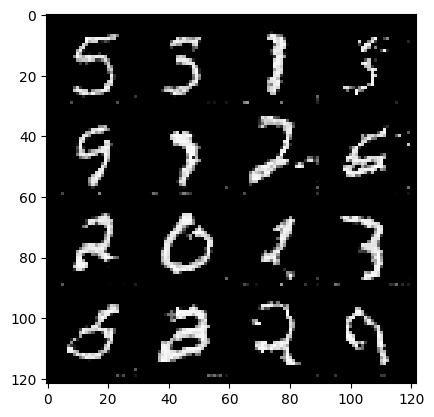

In [ ]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img,_ in tqdm(trainloader): # tqdm progress bar
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, 1, device = device)

    # find loss and update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss and update weights for G

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, 1, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss = G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))

show_tensor_images(fake_img)

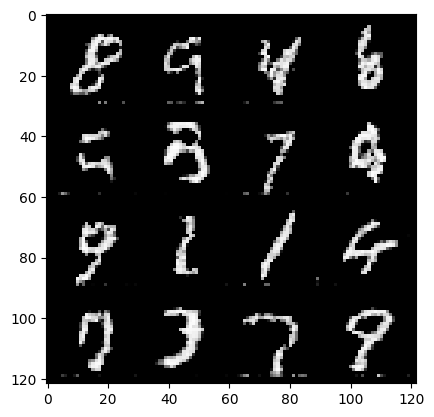

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya